# Relevance Forward Propagation for SEN12MS

In [1]:
from datasets.sen12ms import SEN12MS, Normalize, ToTensor, bands_mean, bands_std, CLASS_NAMES;
from models.networks.resnet import ResNet50;
from models.network_mapper import to_relevance_representation, to_basic_representation;
from utils.Utils import input_mapping, set_seed
import matplotlib.pyplot as plt;
from matplotlib.gridspec import GridSpec
from torch.utils.data import DataLoader;
import seaborn as sns
import torchvision.transforms as transforms;
import os
from config.config import label_split_dir_cfg, data_dir_sen12mscr_cfg, data_dir_sen12ms_cfg, ckpt_path_resnet50_sen12ms_cfg

import torch;
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


## Pretrained Model
| Variable | Options | Explanation |
| --- | --- | --- |
| ckpt_path | string | Path to model checkpoint|

In [2]:
ckpt_path = ckpt_path_resnet50_sen12ms_cfg

In [3]:
checkpoint = torch.load(ckpt_path, map_location="cpu")
model = ResNet50(n_inputs=12, num_classes=10)
model.load_state_dict(checkpoint["model_state_dict"]);

/home/jakob/Documents/PhD/Projects/RFP/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jakob/Documents/PhD/Projects/RFP/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Model Evaluation
#### Load Test Data
**Data Setup**
| Variable | Data Type | Explanation |
| --- | --- | --- |
| data_dir_clear | string | root path of SEN12MS |
| data_dir_cloudy | string | root path of SEN12MSCR |
| label_split_dir | string | path to label_split pickle file |


In [7]:
# Data Setup
data_dir_clear = data_dir_sen12ms_cfg
data_dir_cloudy = data_dir_sen12mscr_cfg
label_split_dir = label_split_dir_cfg

batch_size = 16
img_transform = transforms.Compose([ToTensor(),
                                     Normalize(bands_mean, 
                                               bands_std)])

### Setup Clear and Cloudy Data Set

In [8]:
set_seed(42)
test_data = SEN12MS(path_clear=data_dir_clear, 
                    path_cloudy=data_dir_cloudy,
                    ls_dir=label_split_dir,
                    img_transform=img_transform,
                    label_type="single_label",
                    subset="test",
                    use_cloudy=True,
                    cloud_frac=1,
                    use_s1=True,
                    use_s2=True)
  
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=8)

path clear:  /media/jakob/Expansion/DataSets/SEN12MS
path cloudy:  /media/jakob/Expansion/DataSets/SEN12MSCR


[Load]: 100%|██████████| 18106/18106 [00:05<00:00, 3076.28it/s]


Loaded 18106 files with 12666 Cloudy versions!
loaded 18106 samples from the sen12ms subset test


# Example Visualization
| Variable | Options | Explanation |
| --- | --- | --- |
| num_examples | [num_rows, num_cols] | Number of rows and columns of example images |

In [9]:
# Visualization
num_examples = [5,5]
figsize = [15,15]
fontsize = 10

### Plot Examples Clear and Cloudy

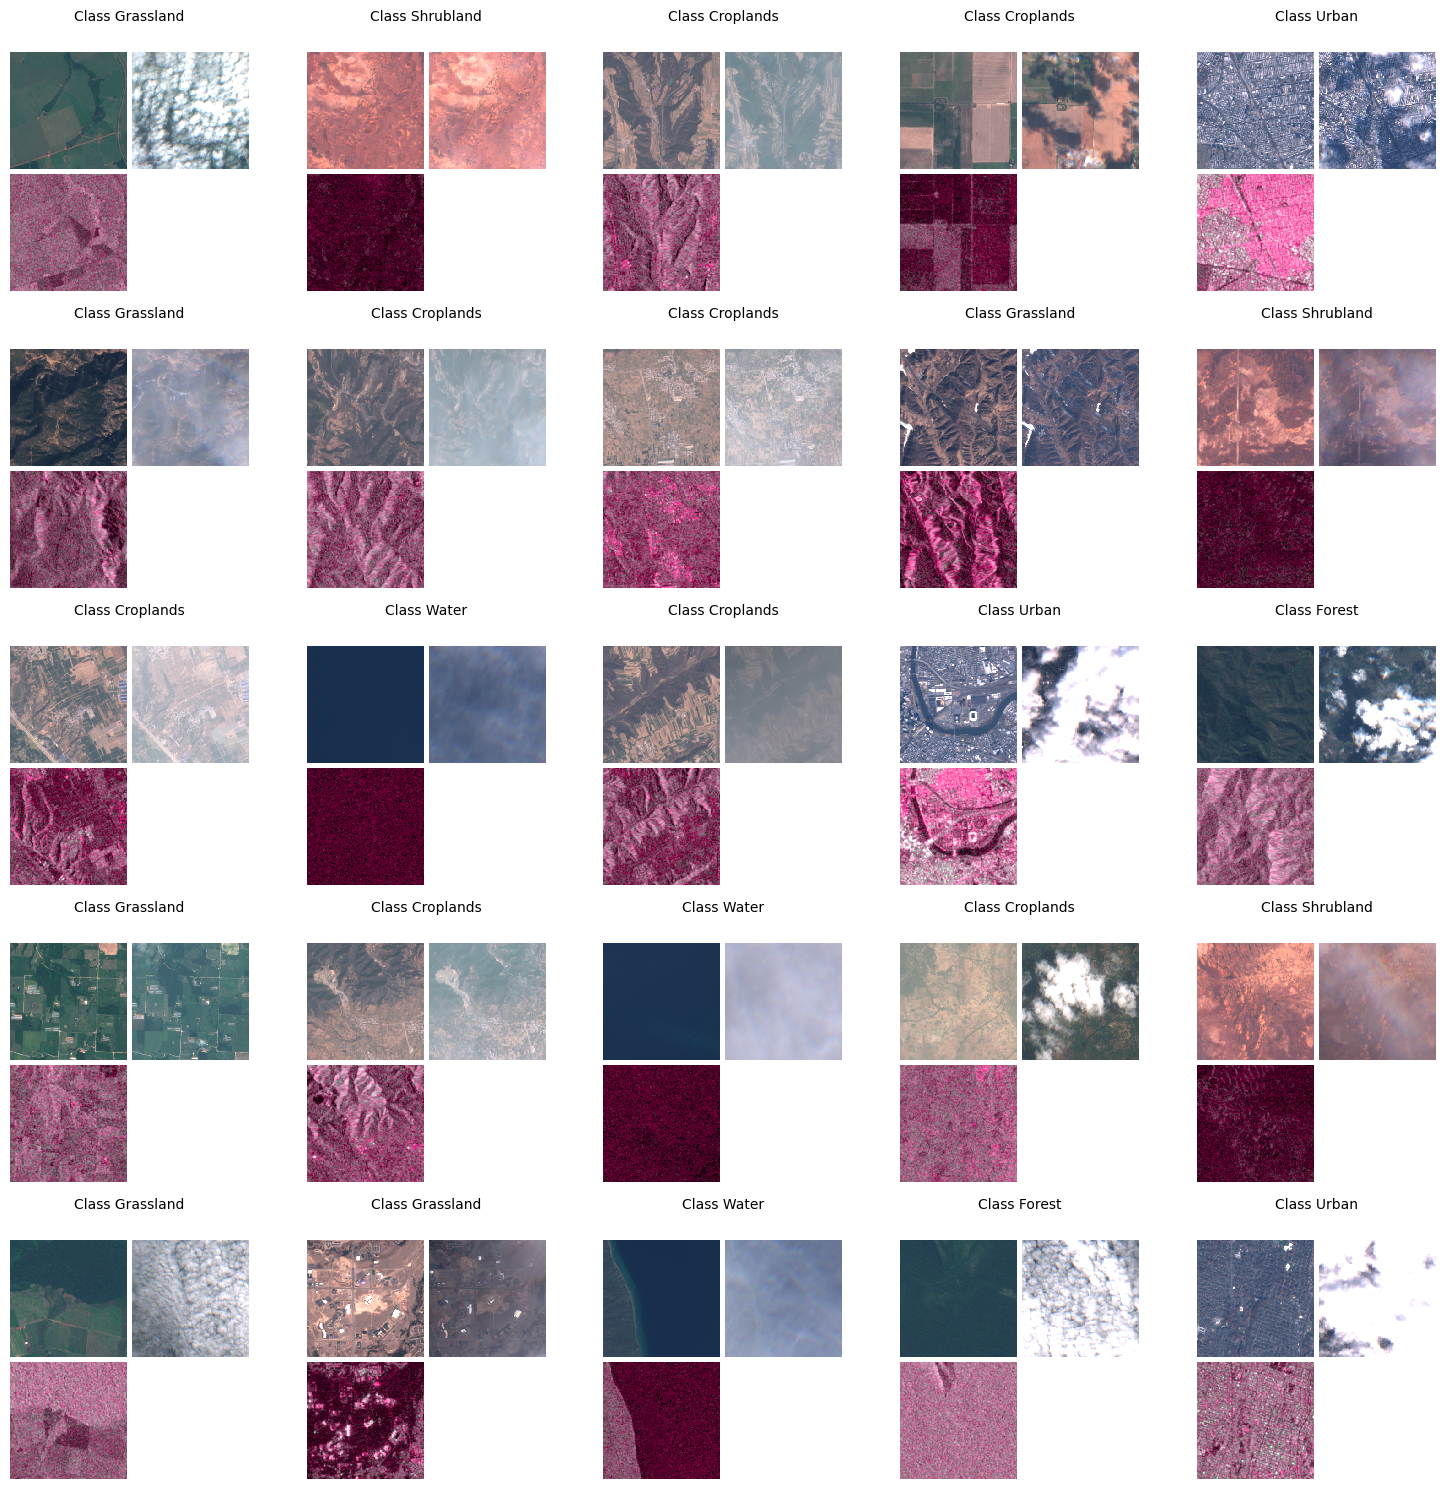

In [10]:
set_seed(42)
test_data.use_cloudy = True
fig, axs = plt.subplots(*num_examples, figsize=figsize)
test_data.plot_imgs(axs, num_examples, fontsize=fontsize)
fig.tight_layout()

# Model Evaluation

## Evaluate Clear Data Set

In [19]:
print("Evaluate Model with Clear Test Set")

criterion = torch.nn.CrossEntropyLoss()
model = model.double().to(device)
model.eval()

test_data.use_cloudy = False
test_data.cloud_frac = 0

with torch.no_grad():
  test_correct_count_clear = 0
  test_total_count_clear = 1e-20
  test_loss_sum_clear = 0
  test_pred_list_clear = []
  test_labels_list_clear = []
  
  for i, data in enumerate(test_data_loader):
    print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]    Acc {test_correct_count_clear/test_total_count_clear}", end="\r")
    label = data["label"].argmax(-1).to(device)
    x = data["image"].double().to(device)

    pred = model(x)

    test_pred_list_clear.append(pred.cpu())
    test_loss = criterion(pred, label)

    test_labels_list_clear.append(label.cpu())
    test_loss_sum_clear += test_loss.cpu().item()
    test_correct_count_clear += (label == pred.argmax(-1)).sum().cpu().item()
    test_total_count_clear += x.shape[-4]

  print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]     " +\
        f"Loss {test_loss_sum_clear/len(test_data_loader):.4f}    "+\
        f"Acc {test_correct_count_clear/test_total_count_clear:.4f}")
  
  test_pred_list_clear = torch.cat(test_pred_list_clear, 0)
  test_labels_list_clear = torch.cat(test_labels_list_clear, 0)


Evaluate Model with Clear Test Set
Eval Test Performance [566 / 566]     Loss 1.9447    Acc 0.6466


##### Save / Load Intermediate Results

In [21]:
# Run Cell to save
os.makedirs("./tmp", exist_ok=True)
torch.save({"test_loss_sum_clear": test_loss_sum_clear,
            "num_batches": len(test_data_loader),
            "test_correct_count_clear": test_correct_count_clear,
            "test_total_count_clear": test_total_count_clear,
            "test_pred_list_clear": test_pred_list_clear,
            "test_labels_list_clear": test_labels_list_clear}, "./tmp/original_normal_clear.pth")

In [18]:
res_dict = torch.load("./tmp/original_normal_clear.pth")
test_loss_sum_clear = res_dict["test_loss_sum_clear"]
test_num_batches_clear = res_dict["num_batches"]
test_correct_count_clear = res_dict["test_correct_count_clear"]
test_total_count_clear = res_dict["test_total_count_clear"]
test_pred_list_clear = res_dict["test_pred_list_clear"]
test_labels_list_clear = res_dict["test_labels_list_clear"]

## Evaluate Cloudy Data Set

In [24]:
print("Evaluate Model with Cloudy Test Set")

criterion = torch.nn.CrossEntropyLoss()
model = model.double().to(device)
model.eval()

test_data.use_cloudy = True
test_data.cloud_frac = 1.0

with torch.no_grad():
  test_correct_count_cloudy = 0
  test_total_count_cloudy = 1e-20
  test_loss_sum_cloudy = 0
  test_pred_list_cloudy = []
  test_labels_list_cloudy = []

  for i, data in enumerate(test_data_loader):
    print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]    Acc {test_correct_count_cloudy/test_total_count_cloudy}", end="\r")
    label = data["label"].argmax(-1).to(device)
    x = data["image"].double().to(device)

    pred = model(x)

    test_pred_list_cloudy.append(pred.cpu())
    test_loss = criterion(pred, label)

    test_labels_list_cloudy.append(label.cpu())
    test_loss_sum_cloudy += test_loss.cpu().item()
    test_correct_count_cloudy += (label == pred.argmax(-1)).sum().cpu().item()
    test_total_count_cloudy += x.shape[-4]

  print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]     " +\
        f"Loss {test_loss_sum_cloudy/len(test_data_loader):.4f}    "+\
        f"Acc {test_correct_count_cloudy/test_total_count_cloudy:.4f}")
  
  test_pred_list_cloudy = torch.cat(test_pred_list_cloudy, 0)


Evaluate Model with Cloudy Test Set
Eval Test Performance [566 / 566]     Loss 3.8009    Acc 0.4364


##### Save / Load Intermediate Results

In [25]:
# Run Cell to save
os.makedirs("./tmp", exist_ok=True)
torch.save({"test_loss_sum_cloudy": test_loss_sum_cloudy,
            "num_batches": len(test_data_loader),
            "test_correct_count_cloudy": test_correct_count_cloudy,
            "test_total_count_cloudy": test_total_count_cloudy,
            "test_pred_list_cloudy": test_pred_list_cloudy,
            "test_labels_list_cloudy": test_labels_list_cloudy}, "./tmp/original_normal_cloudy.pth")

In [19]:
# Run Cell to load
res_dict = torch.load("./tmp/original_normal_cloudy.pth")
test_loss_sum_cloudy = res_dict["test_loss_sum_cloudy"]
test_num_batches_cloudy = res_dict["num_batches"]
test_correct_count_cloudy = res_dict["test_correct_count_cloudy"]
test_total_count_cloudy = res_dict["test_total_count_cloudy"]
test_pred_list_cloudy = res_dict["test_pred_list_cloudy"]
test_labels_list_cloudy = res_dict["test_labels_list_cloudy"]

## Evaluate Clear Data Set on RFP

In [26]:
print("Evaluate RFP Model with Clear Test Set")

criterion = torch.nn.CrossEntropyLoss()
model = to_relevance_representation(model, verbose=0).double().to(device)
model.eval()

test_data.use_cloudy = False
test_data.cloud_frac = 0

with torch.no_grad():
  rfp_test_correct_count_clear = 0
  rfp_test_total_count_clear = 1e-20
  rfp_test_loss_sum_clear = 0
  rfp_test_pred_list_clear = []
  rfp_test_labels_list_clear = []
  rfp_test_id_list_clear = []

  for i, data in enumerate(test_data_loader):
    print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]    Acc {rfp_test_correct_count_clear/rfp_test_total_count_clear}", end="\r")
    label = data["label"].argmax(-1).to(device)
    #x = data["image"].double().to(device)

    x1, x2 = data["image"].split([10,2], dim=-3)
    x1, x2 = input_mapping(x1, x2)
    x = torch.cat([x1,x2], -3).double().to(device=device)

    pred = model(x)

    rfp_test_pred_list_clear.append(pred.cpu())
    test_loss = criterion(pred.sum(0), label)
    rfp_test_labels_list_clear.append(label.cpu())
    rfp_test_id_list_clear += data["id"]
    
    rfp_test_loss_sum_clear += test_loss.cpu().item()
    rfp_test_correct_count_clear += (label == pred.sum(0).argmax(-1)).sum().cpu().item()
    rfp_test_total_count_clear += x.shape[-4]

  print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]     " +\
        f"Loss {rfp_test_loss_sum_clear/len(test_data_loader):.4f}    "+\
        f"Acc {rfp_test_correct_count_clear/rfp_test_total_count_clear:.4f}")
  
  rfp_test_pred_list_clear = torch.cat(rfp_test_pred_list_clear, 1)
  rfp_test_labels_list_clear = torch.cat(rfp_test_labels_list_clear, 0)
model = to_basic_representation(model, verbose=0)

Evaluate RFP Model with Clear Test Set
Monkey patches already applied.
Eval Test Performance [1132 / 1132]     Loss 1.9441    Acc 0.6466
Removed all monkey patches for contribution propagation.


#### Save / Load Intermediate Results

In [27]:
# Run Cell to save
os.makedirs("./tmp", exist_ok=True)
torch.save({"rfp_test_loss_sum_clear": rfp_test_loss_sum_clear,
            "num_batches": len(test_data_loader),
            "rfp_test_correct_count_clear": rfp_test_correct_count_clear,
            "rfp_test_total_count_clear": rfp_test_total_count_clear,
            "rfp_test_pred_list_clear": rfp_test_pred_list_clear,
            "rfp_test_labels_list_clear": rfp_test_labels_list_clear,
            "rfp_test_id_list_clear": rfp_test_id_list_clear}, "./tmp/rfp_clear.pth")

In [21]:
# Run Cell to load
res_dict = torch.load("./tmp/rfp_clear.pth")
print(res_dict.keys())
rfp_test_loss_sum_clear = res_dict["rfp_test_loss_sum_clear"]
rfp_test_num_batches_clear = res_dict["num_batches"]
rfp_test_correct_count_clear = res_dict["rfp_test_correct_count_clear"]
rfp_test_total_count_clear = res_dict["rfp_test_total_count_clear"]
rfp_test_pred_list_clear = res_dict["rfp_test_pred_list_clear"]
rfp_test_labels_list_clear = res_dict["rfp_test_labels_list_clear"]

dict_keys(['rfp_test_loss_sum_cloudy', 'num_batches', 'rfp_test_correct_count_cloudy', 'rfp_test_total_count_cloudy', 'rfp_test_pred_list_cloudy'])


## Evaluate Cloudy Data Set on RFP

In [28]:
print("Evaluate RFP Model with Cloudy Test Set")

criterion = torch.nn.CrossEntropyLoss()
model = to_relevance_representation(model, verbose=0).double().to(device)
model.eval()

test_data.use_cloudy = True
test_data.cloud_frac = 1

with torch.no_grad():
  rfp_test_correct_count_cloudy = 0
  rfp_test_total_count_cloudy = 1e-20
  rfp_test_loss_sum_cloudy = 0
  rfp_test_pred_list_cloudy = []
  rfp_test_labels_list_cloudy = []
  rfp_test_id_list_cloudy = []
  
  for i, data in enumerate(test_data_loader):
    print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]    Acc {rfp_test_correct_count_cloudy/rfp_test_total_count_cloudy}", end="\r")
    label = data["label"].argmax(-1).to(device)
    #x = data["image"].double().to(device)

    x1, x2 = data["image"].double().split([10,2], dim=-3)
    x1, x2 = input_mapping(x1, x2)
    x = torch.cat([x1,x2], -3).to(device=device)

    pred = model(x)

    rfp_test_pred_list_cloudy.append(pred.cpu())
    test_loss = criterion(pred.sum(0), label)
    rfp_test_labels_list_cloudy.append(label.cpu())
    rfp_test_id_list_cloudy += data["id"]

    rfp_test_loss_sum_cloudy += test_loss.cpu().item()
    rfp_test_correct_count_cloudy += (label == pred.sum(0).argmax(-1)).sum().cpu().item()
    rfp_test_total_count_cloudy += x.shape[-4]

  print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]     " +\
        f"Loss {rfp_test_loss_sum_cloudy/len(test_data_loader):.4f}    "+\
        f"Acc {rfp_test_correct_count_cloudy/rfp_test_total_count_cloudy:.4f}")
  
  rfp_test_pred_list_cloudy = torch.cat(rfp_test_pred_list_cloudy, 1)
  rfp_test_labels_list_cloudy = torch.cat(rfp_test_labels_list_cloudy, 0)

model = to_basic_representation(model, verbose=0)

Evaluate RFP Model with Cloudy Test Set
Applied monkey patches for relevance forward propagation.


Eval Test Performance [1132 / 1132]     Loss 3.8006    Acc 0.4364
Removed all monkey patches for contribution propagation.


#### Save / Load Intermediate Results

In [14]:
# Run Cell to save
os.makedirs("./tmp", exist_ok=True)
torch.save({"rfp_test_loss_sum_cloudy": rfp_test_loss_sum_cloudy,
            "num_batches": len(test_data_loader),
            "rfp_test_correct_count_cloudy": rfp_test_correct_count_cloudy,
            "rfp_test_total_count_cloudy": rfp_test_total_count_cloudy,
            "rfp_test_pred_list_cloudy": rfp_test_pred_list_cloudy,
            "rfp_test_labels_list_cloudy": rfp_test_labels_list_cloudy,
            "rfp_test_id_list_cloudy": rfp_test_id_list_cloudy}, "./tmp/rfp_cloudy.pth")

In [22]:
# Run Cell to load
res_dict = torch.load("./tmp/rfp_cloudy.pth")
rfp_test_loss_sum_cloudy = res_dict["rfp_test_loss_sum_cloudy"]
rfp_test_num_batches_cloudy = res_dict["num_batches"]
rfp_test_correct_count_cloudy = res_dict["rfp_test_correct_count_cloudy"]
rfp_test_total_count_cloudy = res_dict["rfp_test_total_count_cloudy"]
rfp_test_pred_list_cloudy = res_dict["rfp_test_pred_list_cloudy"]
rfp_test_labels_list_cloudy = res_dict["rfp_test_labels_list_cloudy"]
rfp_test_id_list_cloudy = res_dict["rfp_test_id_list_cloudy"]

### Similarity Evaluation Clear Data Set

In [23]:
print("Similarity Evaluation RFP and Basic Model")
print()
print("Output shapes")
print(f"    Basic Model:   Test Clear {test_pred_list_clear.shape}   Test Cloudy {test_pred_list_cloudy.shape}")
print(f"      RFP Model:   Test Clear {rfp_test_pred_list_clear.shape}   Test Cloudy {rfp_test_pred_list_cloudy.shape}")
print(f"Loss:")
print(f"    Basic Model:   Test Clear {test_loss_sum_clear/test_num_batches_clear:.6f}   Test Cloudy {test_loss_sum_cloudy/test_num_batches_cloudy:.6f}")
print(f"      RFP Model:   Test Clear {rfp_test_loss_sum_clear/rfp_test_num_batches_clear:.6f}   Test Cloudy {rfp_test_loss_sum_cloudy/rfp_test_num_batches_cloudy:.6f}")
print(f"          Delta:   Test Clear {(rfp_test_loss_sum_clear/rfp_test_num_batches_clear-test_loss_sum_clear/test_num_batches_clear):.6f}   Test Cloudy {(test_loss_sum_cloudy/test_num_batches_cloudy-rfp_test_loss_sum_cloudy/rfp_test_num_batches_cloudy):.6f}")
print()
print(f"Accuracy:")
print(f"    Basic Model:   Test Clear {test_correct_count_clear/test_total_count_clear:.6f}   Test Cloudy {test_correct_count_cloudy/test_total_count_cloudy:.6f}")
print(f"      RFP Model:   Test Clear {rfp_test_correct_count_clear/rfp_test_total_count_clear:.6f}   Test Cloudy {rfp_test_correct_count_cloudy/rfp_test_total_count_cloudy:.6f}")
print(f"          Delta:   Test Clear {(test_correct_count_clear-rfp_test_correct_count_clear):.6f}   Test Cloudy {(test_correct_count_cloudy-rfp_test_correct_count_cloudy):.6f}")
print()
print("Model Output")
print(f"    Mean L1-error:   Test Clear {(test_pred_list_clear-rfp_test_pred_list_clear.sum(0)).abs().mean()}   Test Cloudy {(test_pred_list_cloudy-rfp_test_pred_list_cloudy.sum(0)).abs().mean()}")
print(f"     Max L1-error:   Test Clear {(test_pred_list_clear-rfp_test_pred_list_clear.sum(0)).abs().max()}   Test Cloudy {(test_pred_list_cloudy-rfp_test_pred_list_cloudy.sum(0)).abs().max()}")


Similarity Evaluation RFP and Basic Model

Output shapes
    Basic Model:   Test Clear torch.Size([18106, 10])   Test Cloudy torch.Size([18106, 10])
      RFP Model:   Test Clear torch.Size([3, 18106, 10])   Test Cloudy torch.Size([3, 18106, 10])
Loss:
    Basic Model:   Test Clear 1.944662   Test Cloudy 3.800922
      RFP Model:   Test Clear 3.800623   Test Cloudy 3.800623
          Delta:   Test Clear 1.855961   Test Cloudy 0.000299

Accuracy:
    Basic Model:   Test Clear 0.646636   Test Cloudy 0.436375
      RFP Model:   Test Clear 0.436375   Test Cloudy 0.436375
          Delta:   Test Clear 3807.000000   Test Cloudy 0.000000

Model Output
    Mean L1-error:   Test Clear 3.4296272082384265   Test Cloudy 6.842279540521829e-15
     Max L1-error:   Test Clear 35.25453180112221   Test Cloudy 6.039613253960852e-14


# Relevance Visualizations Clear
Visualization of sample-wise relevance of data source 1 (L), data source 2 (R) and the sample-wise difference (L-R).

In [ ]:
# uses contributions and labels of previous cells

data = {}

num_classes = rfp_test_pred_list.shape[-1]
num_samples = len(rfp_test_pred_list[0])

print(f"Density over {num_samples} points!")
text_size = 16
title_size = 18
fig, axs = plt.subplots(nrows=1, ncols=num_classes+1, figsize=(20,5))

data["Contribution"]  =  []
data["Source"] = []

for i in range(num_classes+1):

  if i > 0:
    ids_filter = [k for k in range(len(rfp_labels_clear)) if rfp_labels_clear[k] == i-1]
    data["Contribution"] = [rfp_test_pred_list_clear[1,id,i-1].item() for id in ids_filter] + \
                            [rfp_test_pred_list_clear[2,id,i-1].item() for id in ids_filter] + \
                            [rfp_test_pred_list_clear[1,id,i-1].item()-rfp_test_pred_list_clear[2,id,i-1].item() for id in ids_filter]
  else:
    ids_filter = range(len(rfp_labels))
    data["Contribution"] = [rfp_test_pred_list_clear[1,id,rfp_labels_clear[id]].item() for id in ids_filter] + \
                            [rfp_test_pred_list_clear[2,id,rfp_labels_clear[id]].item() for id in ids_filter] + \
                            [rfp_test_pred_list_clear[1,id,rfp_labels_clear[id]].item()-rfp_test_pred_list_clear[2,id,rfp_labels_clear[id]].item() for id in ids_filter]


  data["Source"] = ["L"] * len(ids_filter) + ["R"] * len(ids_filter) + ["L-R"] * len(ids_filter)

  sns.violinplot(data=data,
                  x="Source",
                  y="Contribution",
                  hue="Source",
                  split=False, 
                  ax=axs[i],
                  orient="v",
                  saturation=0.8
                  )
  
  if i==0:
    axs[i].set_ylabel('Relevance Value (RFP)', fontsize=text_size)
    axs[i].tick_params(axis='x', labelsize=text_size)
    axs[i].tick_params(axis='y', labelsize=text_size)

    axs[i].tick_params(axis='x', labelsize=text_size)
    axs[i].tick_params(axis='y', labelsize=text_size)
  else:
    axs[i].tick_params(axis='x', labelsize=text_size)
    axs[i].tick_params(axis='y', labelsize=text_size)
    axs[i].get_yaxis().set_visible(False)

  axs[i].set_ylim([-25,25])
  axs[i].hlines(0, -0.5, 2.5, linestyle="--", color="red")

  if i == 0:
    axs[i].set_title(f"Total", fontsize=text_size)  
  else:
    axs[i].set_title(f"Class {i-1}", fontsize=text_size)
  
  axs[i].set_xlabel('')

fig.suptitle(f"Class-wise Data Source Relevance on SEN12MS Clear Test Set", fontsize=title_size)
fig.tight_layout()

NameError: name 'rfp_test_pred_list' is not defined

## Evaluate Cloudy Data Set

In [ ]:
print("Evaluate Model")

criterion = torch.nn.CrossEntropyLoss()
model = model.double().to(device)
with torch.no_grad():
  train_correct_count, test_correct_count = 0, 0
  train_total_count, test_total_count = 0, 0
  train_loss_sum, test_loss_sum = 0, 0
  train_pred_list = []
  test_pred_list = []

  for i, data in enumerate(test_data_loader_cloudy):
    print(f"Eval Test Performance [{i+1} / {len(test_data_loader_cloudy)}]    ", end="\r")
    label = data["label"].to(device)
    x1 = data["img1"].double().to(device)
    x2 = data["img2"].double().to(device)
    pred = model(x1,x2)

    test_pred_list.append(pred.cpu())
    test_loss = criterion(pred, label)

    test_loss_sum += test_loss.cpu().item()
    test_correct_count += (label == pred.argmax(-1)).sum().cpu().item()
    test_total_count += x1.shape[-4]

  print(f"Eval Test Performance [{i+1} / {len(test_data_loader_cloudy)}]     " +\
        f"Loss {test_loss_sum/len(test_data_loader_cloudy):.4f}    "+\
        f"Acc {test_correct_count/test_total_count:.4f}")
  
  test_pred_list = torch.cat(test_pred_list, 0)


Evaluate Model


NameError: name 'model' is not defined

### Relevance Evaluation Cloudy Data Set

In [ ]:
print("Evaluate RFP-Model")

model = to_relevance_representation(model=model, verbose=0)
model = model.double().to(device)

with torch.no_grad():
  rfp_train_pred_list = []
  rfp_test_pred_list = []
  rfp_labels = []

  rfp_test_correct_count = 0
  rfp_test_total_count = 0
  rfp_test_loss_sum = 0

  for i, data in enumerate(test_data_loader_cloudy):
    print(f"Eval Test Performance [{i+1} / {len(test_data_loader_cloudy)}]    ", end="\r")
    label = data["label"].to(device)

    x1, x2 = input_mapping(data["img1"], data["img2"])

    pred = model(x1.double().to(device),x2.double().to(device))

    rfp_test_pred_list.append(pred.cpu())
    rfp_labels.append(label.cpu())

    rfp_test_loss_sum += criterion(pred.sum(0), label).cpu().item()
    rfp_test_correct_count += (label == pred.sum(0).argmax(-1)).sum().cpu().item()
    rfp_test_total_count += x1.shape[-4]
    
  print(f"Eval Test Performance [{i+1} / {len(test_data_loader_cloudy)}]     " +\
        f"Loss {rfp_test_loss_sum/len(test_data_loader_cloudy):.4f}    "+\
        f"Acc {rfp_test_correct_count/rfp_test_total_count:.4f}")
  
model = to_basic_representation(model=model, verbose=0)

rfp_labels = torch.cat(rfp_labels, 0)
rfp_test_pred_list = torch.cat(rfp_test_pred_list, -2)

print(f"Predictions Shape: ", rfp_test_pred_list.shape)

### Similarity Evaluation Cloduy Data Set

In [ ]:
print("Similarity Evaluation RFP and Basic Model")
print()
print("Output shapes")
print(f"    Basic Model:   Test {test_pred_list.shape}")
print(f"      RFP Model:   Test {rfp_test_pred_list.shape}")
print(f"Loss:")
print(f"    Basic Model:   Test {test_loss_sum/len(test_data_loader_cloudy):.6f}")
print(f"      RFP Model:   Test {rfp_test_loss_sum/len(test_data_loader_cloudy):.6f}")
print(f"          Delta:   Test {(test_loss_sum-rfp_test_loss_sum)/len(test_data_loader_cloudy):.6f}")
print()
print(f"Accuracy:")
print(f"    Basic Model:  TTest {test_correct_count/test_total_count:.6f}")
print(f"      RFP Model:   Test {rfp_test_correct_count/rfp_test_total_count:.6f}")
print(f"          Delta:   Test {(test_correct_count-rfp_test_correct_count):.6f}")
print()
print("Model Output")
print(f"    Mean L1-error:   Test {(test_pred_list-rfp_test_pred_list.sum(0)).abs().mean()}")
print(f"     Max L1-error:   Test {(test_pred_list-rfp_test_pred_list.sum(0)).abs().max()}")


Similarity Evaluation RFP and Basic Model

Output shapes
    Basic Model:   Test torch.Size([10000, 10])
      RFP Model:   Test torch.Size([3, 10000, 10])
Loss:
    Basic Model:   Test 0.035064
      RFP Model:   Test 0.035064
          Delta:   Test 0.000000

Accuracy:
    Basic Model:  TTest 0.989400
      RFP Model:   Test 0.989400
          Delta:   Test 0.000000

Model Output
    Mean L1-error:   Test 2.522541190687344e-15
     Max L1-error:   Test 3.552713678800501e-14


# Relevance Visualizations Cloudy
Visualization of sample-wise relevance of data source 1 (L), data source 2 (R) and the sample-wise difference (L-R).

Density over 10000 points!


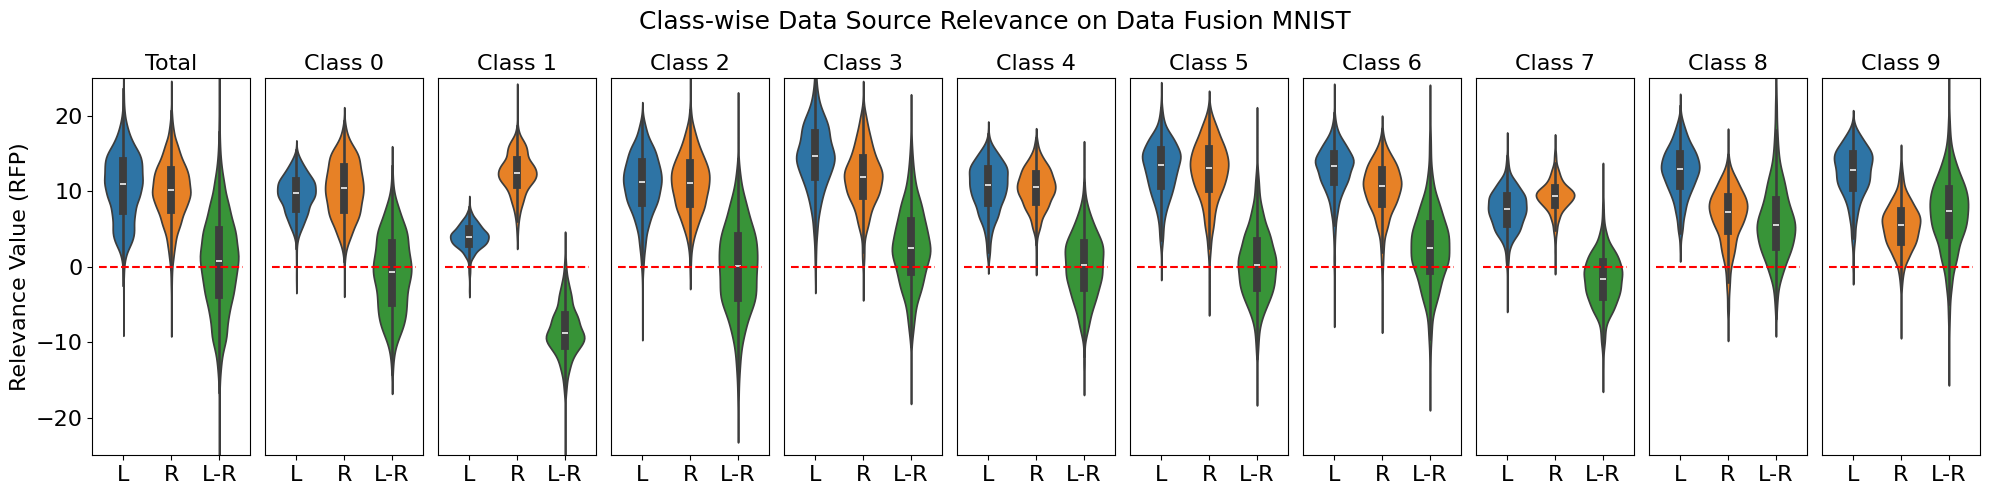

In [ ]:
# uses contributions and labels of previous cells

data = {}

num_classes = rfp_test_pred_list.shape[-1]
num_samples = len(rfp_test_pred_list[0])

print(f"Density over {num_samples} points!")
text_size = 16
title_size = 18
fig, axs = plt.subplots(nrows=1, ncols=num_classes+1, figsize=(20,5))

data["Contribution"]  =  []
data["Source"] = []

for i in range(num_classes+1):

  if i > 0:
    ids_filter = [k for k in range(len(rfp_labels)) if rfp_labels[k] == i-1]
    data["Contribution"] = [rfp_test_pred_list[1,id,i-1].item() for id in ids_filter] + \
                            [rfp_test_pred_list[2,id,i-1].item() for id in ids_filter] + \
                            [rfp_test_pred_list[1,id,i-1].item()-rfp_test_pred_list[2,id,i-1].item() for id in ids_filter]
  else:
    ids_filter = range(len(rfp_labels))
    data["Contribution"] = [rfp_test_pred_list[1,id,rfp_labels[id]].item() for id in ids_filter] + \
                            [rfp_test_pred_list[2,id,rfp_labels[id]].item() for id in ids_filter] + \
                            [rfp_test_pred_list[1,id,rfp_labels[id]].item()-rfp_test_pred_list[2,id,rfp_labels[id]].item() for id in ids_filter]


  data["Source"] = ["L"] * len(ids_filter) + ["R"] * len(ids_filter) + ["L-R"] * len(ids_filter)

  sns.violinplot(data=data,
                  x="Source",
                  y="Contribution",
                  hue="Source",
                  split=False, 
                  ax=axs[i],
                  orient="v",
                  saturation=0.8
                  )
  
  if i==0:
    axs[i].set_ylabel('Relevance Value (RFP)', fontsize=text_size)
    axs[i].tick_params(axis='x', labelsize=text_size)
    axs[i].tick_params(axis='y', labelsize=text_size)

    axs[i].tick_params(axis='x', labelsize=text_size)
    axs[i].tick_params(axis='y', labelsize=text_size)
  else:
    axs[i].tick_params(axis='x', labelsize=text_size)
    axs[i].tick_params(axis='y', labelsize=text_size)
    axs[i].get_yaxis().set_visible(False)

  axs[i].set_ylim([-25,25])
  axs[i].hlines(0, -0.5, 2.5, linestyle="--", color="red")

  if i == 0:
    axs[i].set_title(f"Total", fontsize=text_size)  
  else:
    axs[i].set_title(f"Class {i-1}", fontsize=text_size)
  
  axs[i].set_xlabel('')

fig.suptitle(f"Class-wise Data Source Relevance on Data Fusion MNIST", fontsize=title_size)
fig.tight_layout()

## Example Visualization

| Plot Number | Number of Columns | Number of Rows | Content |
| --- | ---| --- | --- |
| 1st Plot | ncols | 10 | ncols examples per class 
| 2nd Plot | ncols | nrows | examples of correct predictions
| 3rd Plot | ncols | nrows | examples of false predictions

In [ ]:
nrows = 10
ncols = 2

### Class-wise Examples

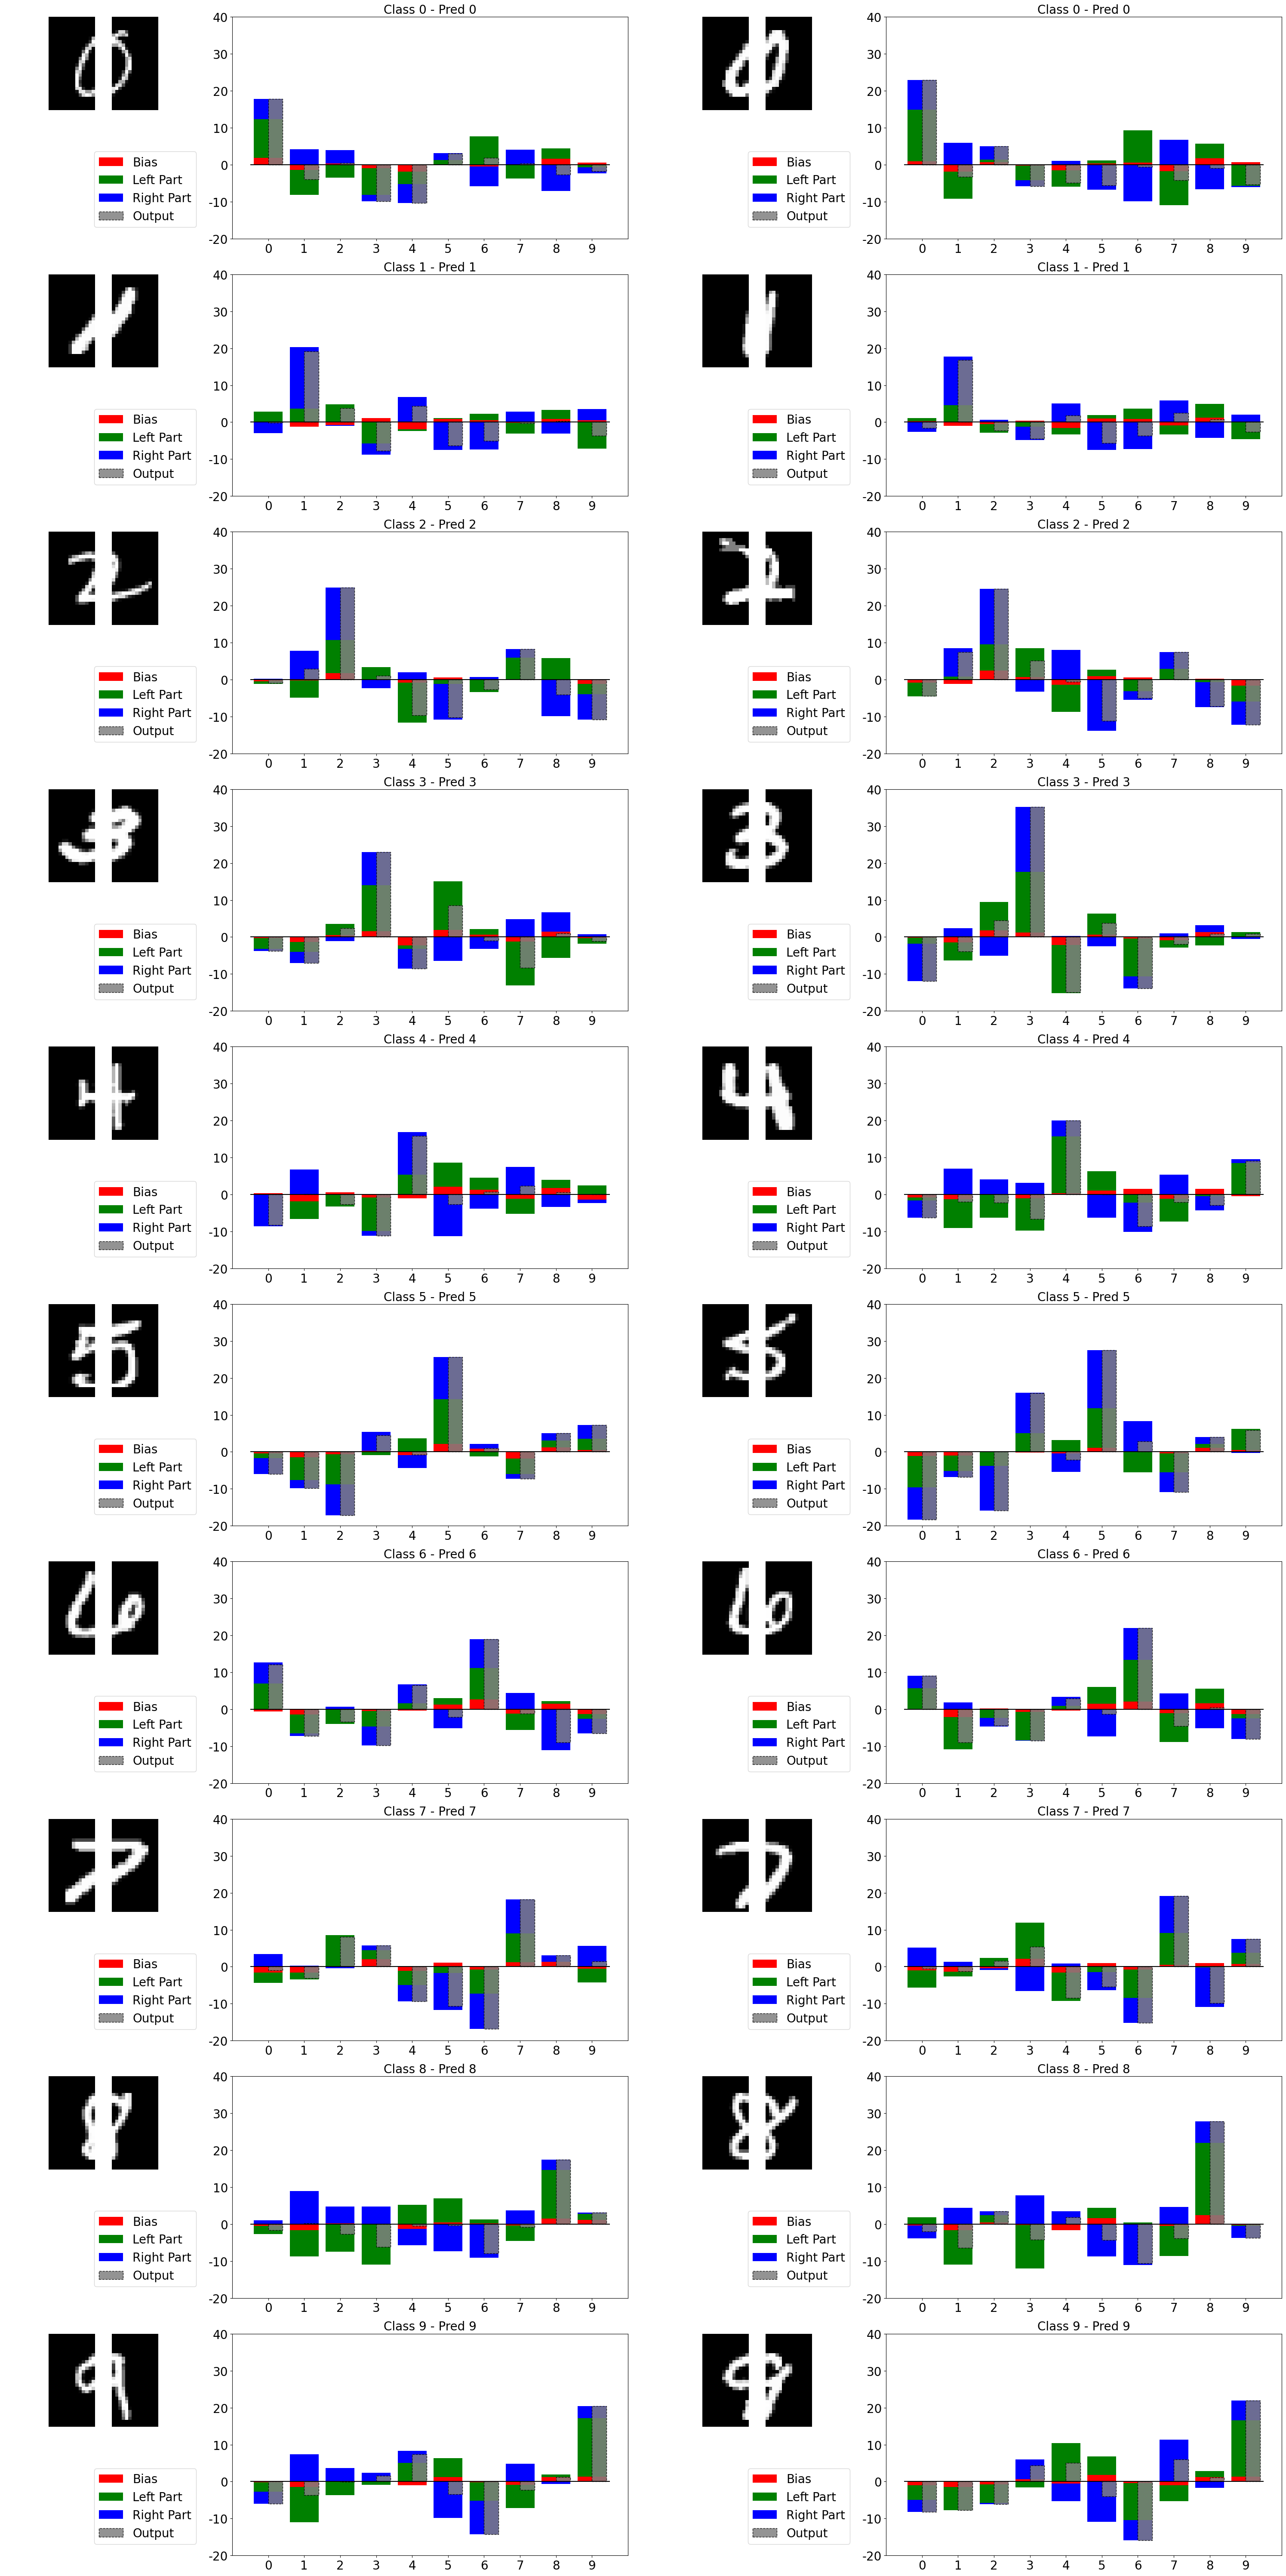

In [ ]:
set_seed(42)

fig = plt.figure(figsize=(30,60))
fontsize = 20

gs = GridSpec(2*nrows, 2*ncols, 
              figure=fig, 
              height_ratios=nrows * [0.5,0.5], 
              width_ratios=ncols * [0.5, 1])

labels_str = ["Bias", "Left Part", "Right Part"]
for i in range(10):

  sample_ids = [idx for idx in torch.randperm(len(test_data)) if test_data.orig_labels1[idx] == i]
  
  for j in range(ncols):

    sub_sample_id = sample_ids[j]

    data1 = test_data[sub_sample_id]
    data2 = test_data[sub_sample_id]

    ax_tl = fig.add_subplot(gs[2*i, 2*j])
    ax_tr = fig.add_subplot(gs[2*i+1, 2*j])
    ax_b = fig.add_subplot(gs[2*i:2*i+2, 2*j+1])
    
    ax_tl.axis('off')
    ax_tl.matshow(torch.cat([data1["img1"][0], torch.ones([28,5]), data2["img2"][0]], 1), cmap="gray")

    plt.bar(range(10), rfp_test_pred_list[0,sample_ids[j]], label=labels_str[0], color='r')
    plt.bar(range(10), rfp_test_pred_list[1,sample_ids[j]].clip(min=0), bottom=rfp_test_pred_list[:1,sample_ids[j]].clip(min=0).sum(0), label=labels_str[1], color='g')
    plt.bar(range(10), rfp_test_pred_list[1,sample_ids[j]].clip(max=0), bottom=rfp_test_pred_list[:1,sample_ids[j]].clip(max=0).sum(0), color='g')

    ax_b.bar(range(10), rfp_test_pred_list[2,sample_ids[j]].clip(min=0), bottom=rfp_test_pred_list[:2,sample_ids[j]].clip(min=0).sum(0), label=labels_str[2], color='b')
    ax_b.bar(range(10), rfp_test_pred_list[2,sample_ids[j]].clip(max=0), bottom=rfp_test_pred_list[:2,sample_ids[j]].clip(max=0).sum(0), color='b')
    
    ax_b.bar(torch.arange(10)+0.2, rfp_test_pred_list[:3,sample_ids[j]].sum(0), label="Output", width=0.4, color='gray', alpha=0.85, linestyle="--", edgecolor="black")
    ax_b.hlines(y=0,xmin=-0.5, xmax=9.5, color="black")
    ax_b.set_ylim([-20,40])     
    ax_b.set_xticks(range(10))

    ax_b.set_xticks(range(10), range(10), fontsize=fontsize)
    ax_b.set_yticks(range(-20,41,10), range(-20,41,10), fontsize=fontsize)

    ax_b.set_title(f"Class {data1['label']} - Pred {rfp_test_pred_list[:3,sub_sample_id].sum(0).argmax(-1).item()}", fontsize=fontsize)
    ax_tr.axis('off')
    ax_tr.legend(*ax_b.get_legend_handles_labels(), fontsize=fontsize)

  fig.tight_layout()


### Random Correc Predictions

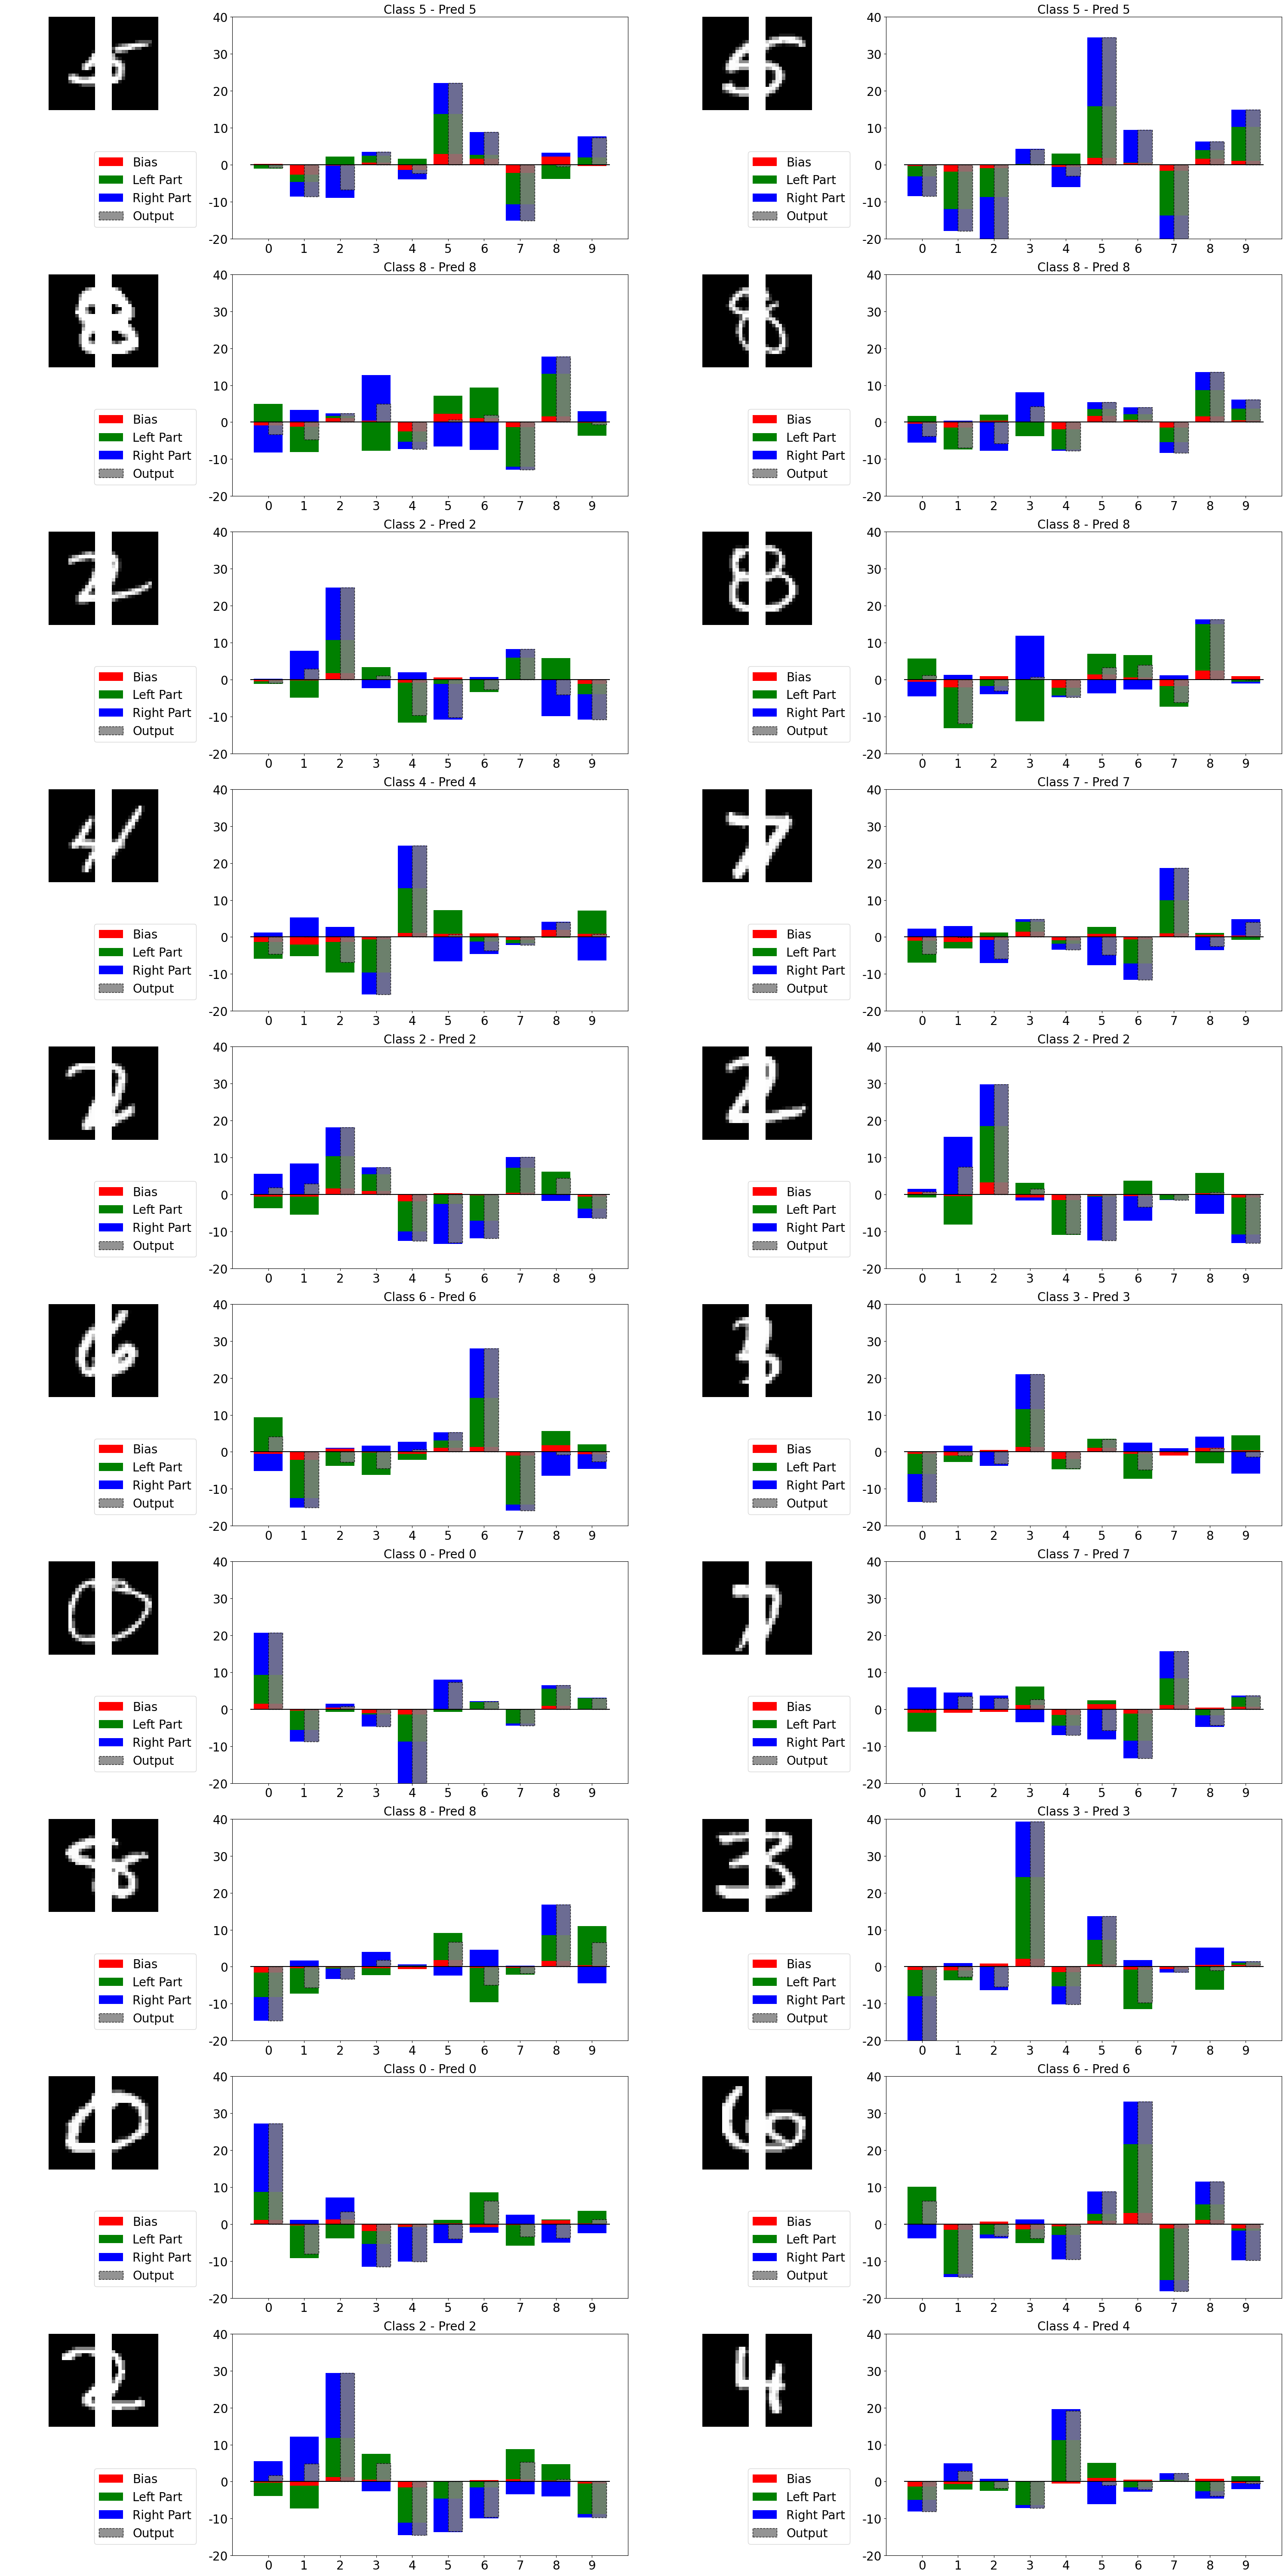

In [ ]:
set_seed(42)

fig = plt.figure(figsize=(30,60))
fontsize = 20

gs = GridSpec(2*nrows, 2*ncols, 
              figure=fig, 
              height_ratios=nrows * [0.5,0.5], 
              width_ratios=ncols * [0.5, 1])

labels_str = ["Bias", "Left Part", "Right Part"]
preds = rfp_test_pred_list.sum(0).argmax(-1)
for i in range(nrows):

  sample_ids = [idx for idx in torch.randperm(len(test_data)) if test_data.orig_labels1[idx] == preds[idx]]
  
  for j in range(ncols):

    sub_sample_id = sample_ids[j]

    data1 = test_data[sub_sample_id]
    data2 = test_data[sub_sample_id]

    ax_tl = fig.add_subplot(gs[2*i, 2*j])
    ax_tr = fig.add_subplot(gs[2*i+1, 2*j])
    ax_b = fig.add_subplot(gs[2*i:2*i+2, 2*j+1])
    
    ax_tl.axis('off')
    ax_tl.matshow(torch.cat([data1["img1"][0], torch.ones([28,5]), data2["img2"][0]], 1), cmap="gray")

    plt.bar(range(10), rfp_test_pred_list[0,sample_ids[j]], label=labels_str[0], color='r')
    plt.bar(range(10), rfp_test_pred_list[1,sample_ids[j]].clip(min=0), bottom=rfp_test_pred_list[:1,sample_ids[j]].clip(min=0).sum(0), label=labels_str[1], color='g')
    plt.bar(range(10), rfp_test_pred_list[1,sample_ids[j]].clip(max=0), bottom=rfp_test_pred_list[:1,sample_ids[j]].clip(max=0).sum(0), color='g')

    ax_b.bar(range(10), rfp_test_pred_list[2,sample_ids[j]].clip(min=0), bottom=rfp_test_pred_list[:2,sample_ids[j]].clip(min=0).sum(0), label=labels_str[2], color='b')
    ax_b.bar(range(10), rfp_test_pred_list[2,sample_ids[j]].clip(max=0), bottom=rfp_test_pred_list[:2,sample_ids[j]].clip(max=0).sum(0), color='b')
    
    ax_b.bar(torch.arange(10)+0.2, rfp_test_pred_list[:3,sample_ids[j]].sum(0), label="Output", width=0.4, color='gray', alpha=0.85, linestyle="--", edgecolor="black")
    ax_b.hlines(y=0,xmin=-0.5, xmax=9.5, color="black")
    ax_b.set_ylim([-20,40])     
    ax_b.set_xticks(range(10))

    ax_b.set_xticks(range(10), range(10), fontsize=fontsize)
    ax_b.set_yticks(range(-20,41,10), range(-20,41,10), fontsize=fontsize)

    ax_b.set_title(f"Class {data1['label']} - Pred {rfp_test_pred_list[:3,sub_sample_id].sum(0).argmax(-1).item()}", fontsize=fontsize)
    ax_tr.axis('off')
    ax_tr.legend(*ax_b.get_legend_handles_labels(), fontsize=fontsize)

  fig.tight_layout()


### Random False Predictions

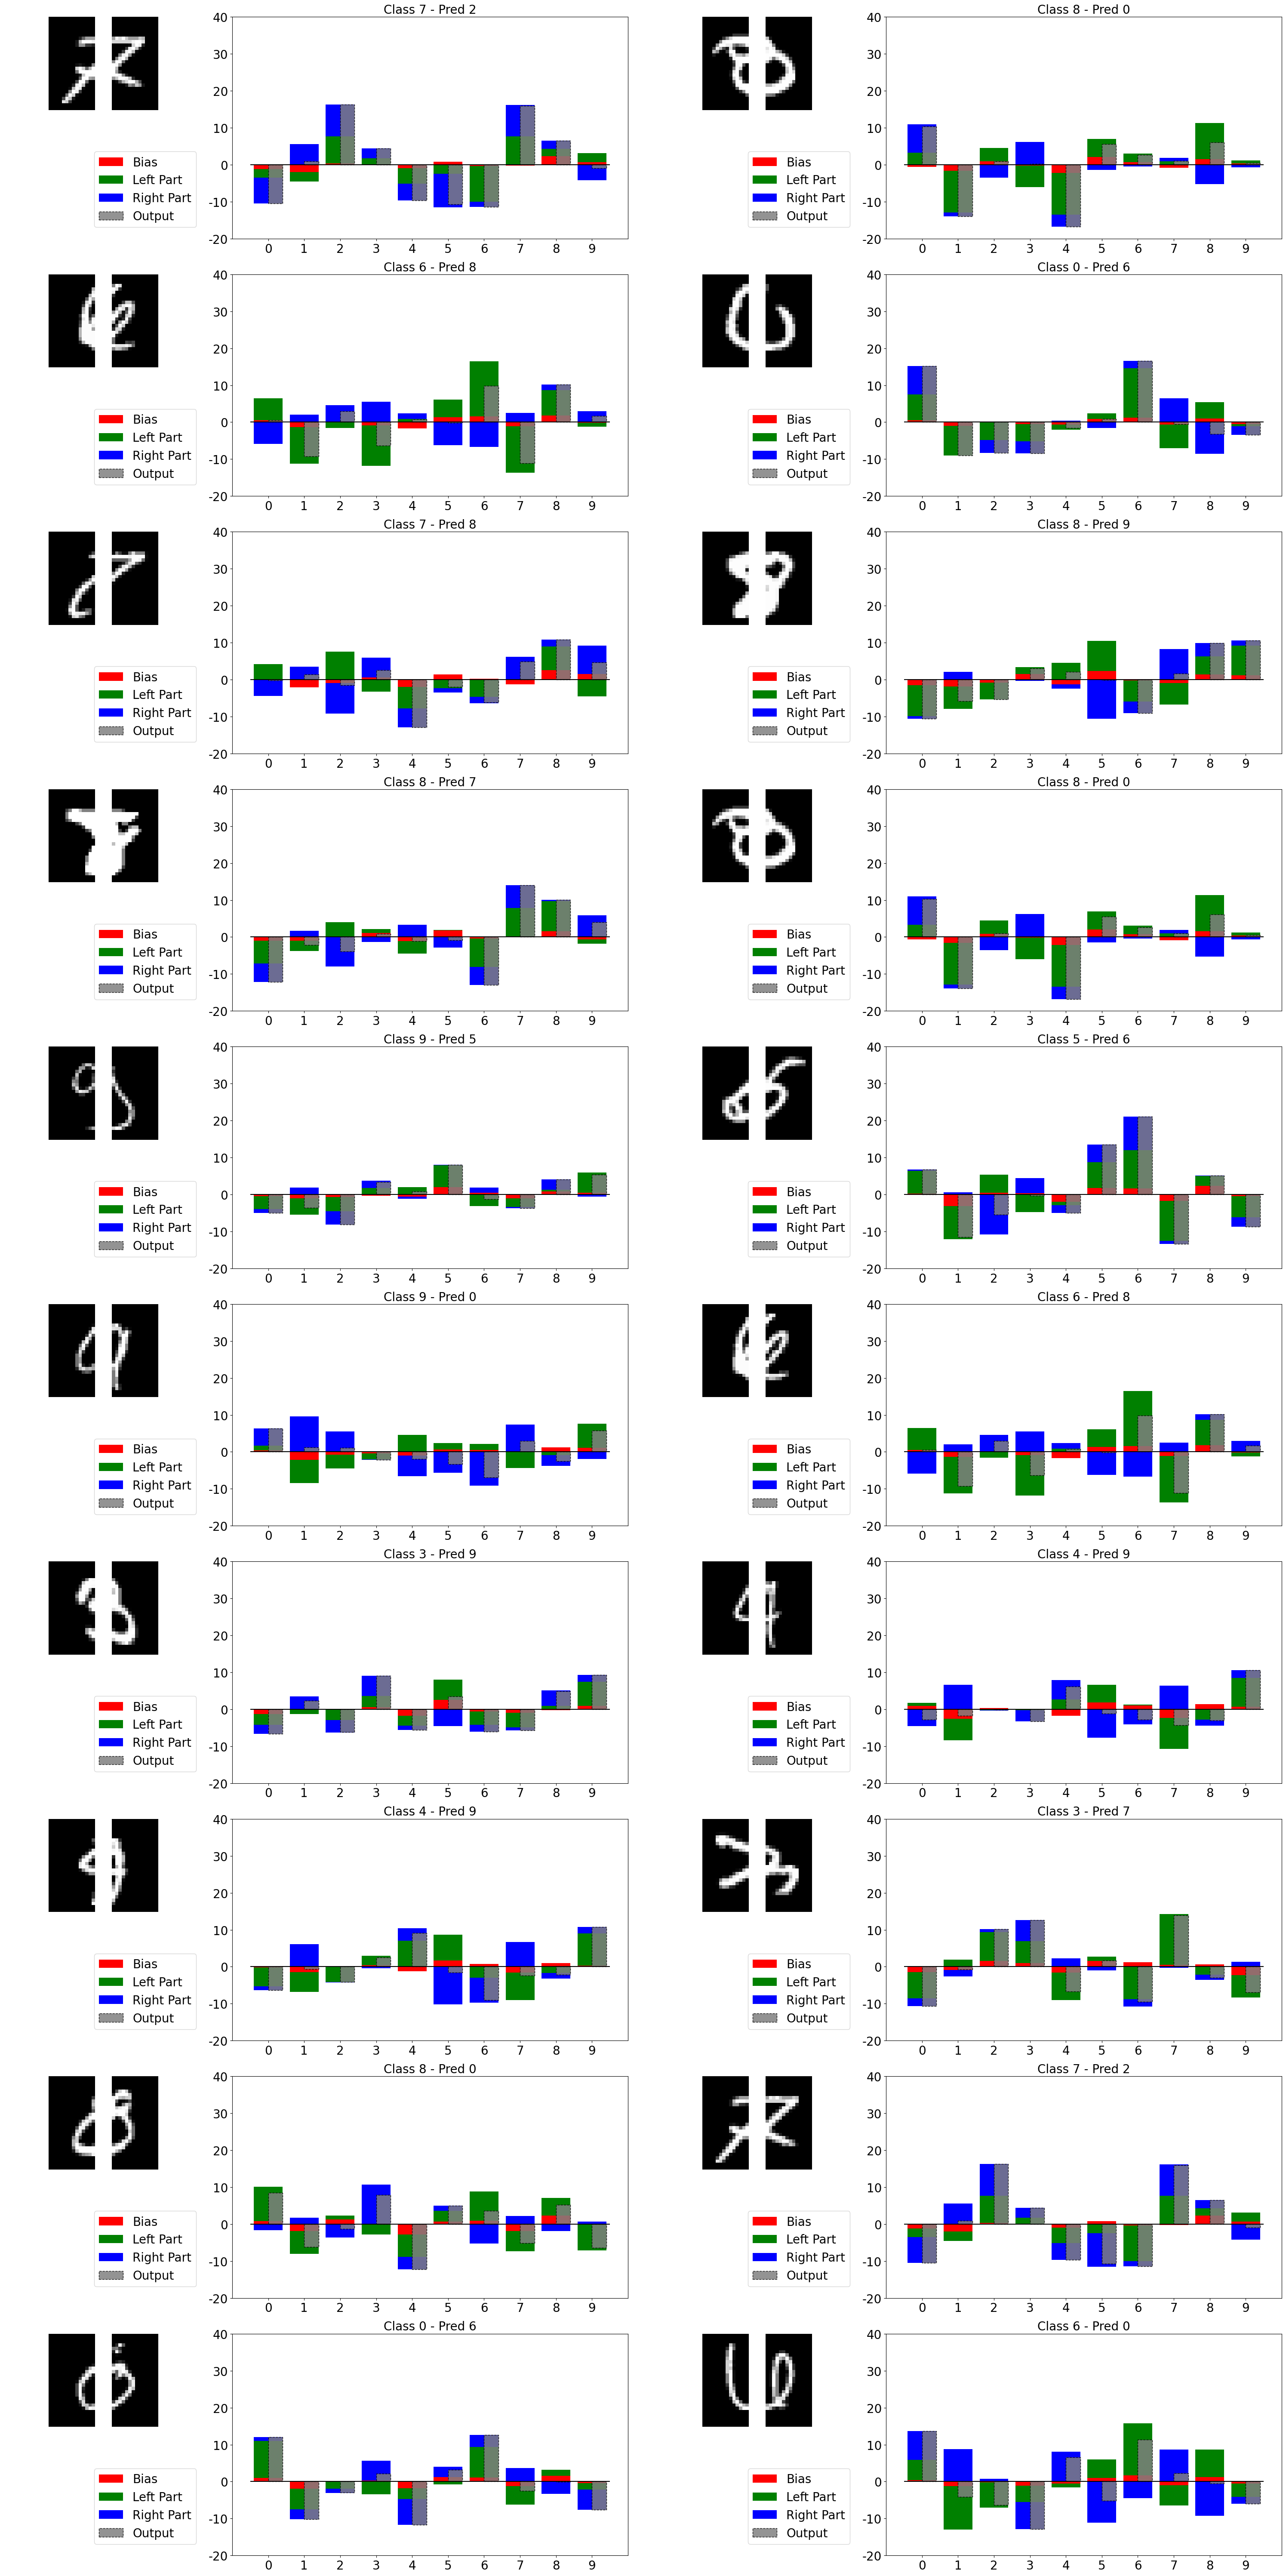

In [ ]:
set_seed(42)

fig = plt.figure(figsize=(30,60))
fontsize = 20

gs = GridSpec(2*nrows, 2*ncols, 
              figure=fig, 
              height_ratios=nrows * [0.5,0.5], 
              width_ratios=ncols * [0.5, 1])

labels_str = ["Bias", "Left Part", "Right Part"]
preds = rfp_test_pred_list.sum(0).argmax(-1)
for i in range(nrows):

  sample_ids = [idx for idx in torch.randperm(len(test_data)) if test_data.orig_labels1[idx] != preds[idx]]
  
  for j in range(ncols):

    sub_sample_id = sample_ids[j]

    data1 = test_data[sub_sample_id]
    data2 = test_data[sub_sample_id]

    ax_tl = fig.add_subplot(gs[2*i, 2*j])
    ax_tr = fig.add_subplot(gs[2*i+1, 2*j])
    ax_b = fig.add_subplot(gs[2*i:2*i+2, 2*j+1])
    
    ax_tl.axis('off')
    ax_tl.matshow(torch.cat([data1["img1"][0], torch.ones([28,5]), data2["img2"][0]], 1), cmap="gray")

    plt.bar(range(10), rfp_test_pred_list[0,sample_ids[j]], label=labels_str[0], color='r')
    plt.bar(range(10), rfp_test_pred_list[1,sample_ids[j]].clip(min=0), bottom=rfp_test_pred_list[:1,sample_ids[j]].clip(min=0).sum(0), label=labels_str[1], color='g')
    plt.bar(range(10), rfp_test_pred_list[1,sample_ids[j]].clip(max=0), bottom=rfp_test_pred_list[:1,sample_ids[j]].clip(max=0).sum(0), color='g')

    ax_b.bar(range(10), rfp_test_pred_list[2,sample_ids[j]].clip(min=0), bottom=rfp_test_pred_list[:2,sample_ids[j]].clip(min=0).sum(0), label=labels_str[2], color='b')
    ax_b.bar(range(10), rfp_test_pred_list[2,sample_ids[j]].clip(max=0), bottom=rfp_test_pred_list[:2,sample_ids[j]].clip(max=0).sum(0), color='b')
    
    ax_b.bar(torch.arange(10)+0.2, rfp_test_pred_list[:3,sample_ids[j]].sum(0), label="Output", width=0.4, color='gray', alpha=0.85, linestyle="--", edgecolor="black")
    ax_b.hlines(y=0,xmin=-0.5, xmax=9.5, color="black")
    ax_b.set_ylim([-20,40])     
    ax_b.set_xticks(range(10))

    ax_b.set_xticks(range(10), range(10), fontsize=fontsize)
    ax_b.set_yticks(range(-20,41,10), range(-20,41,10), fontsize=fontsize)

    ax_b.set_title(f"Class {data1['label']} - Pred {rfp_test_pred_list[:3,sub_sample_id].sum(0).argmax(-1).item()}", fontsize=fontsize)
    ax_tr.axis('off')
    ax_tr.legend(*ax_b.get_legend_handles_labels(), fontsize=fontsize)

  fig.tight_layout()
